In [2]:
# Import libraries
#参考链接  https://blog.csdn.net/cxg1105553864/article/details/91693158
#https://blog.csdn.net/weixin_45716534/article/details/121255475
#https://dandelioncloud.cn/article/details/1526043771326447617/
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Defaults
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.rcParams['figure.figsize'] = (20.0, 10.0) #画布大小
plt.rcParams.update({'font.size': 12}) #字体大小
plt.style.use('ggplot') #风格

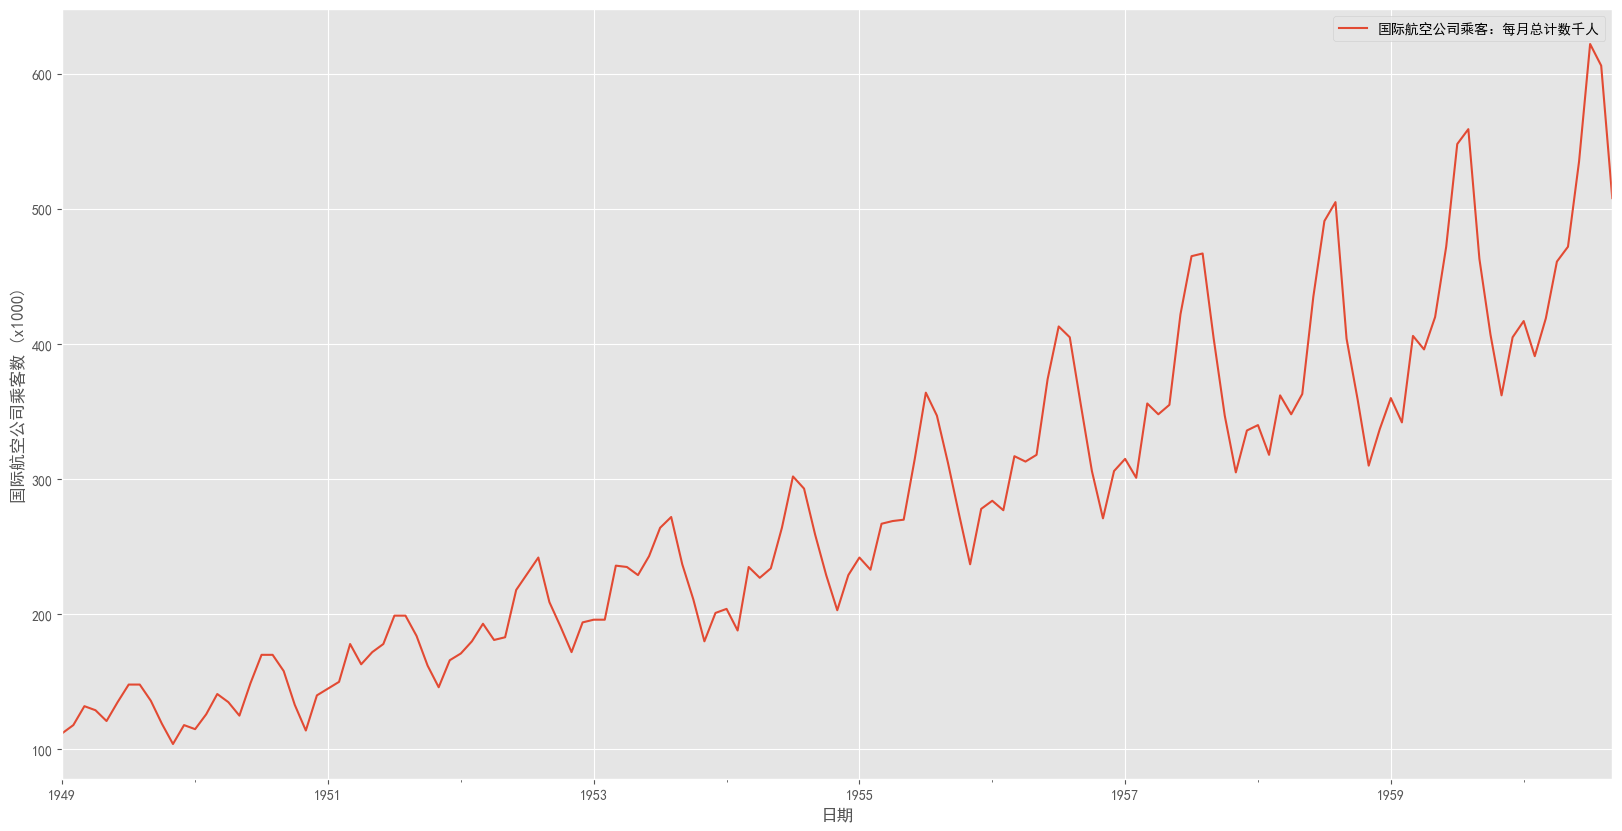

In [3]:
# Load the data
data = pd.read_csv('international-airline-passengers.csv', engine='python',skipfooter=3,encoding="gbk") #读取数据
# A bit of pre-processing to make it nicer
data['Month']=pd.to_datetime(data['Month'], format='%Y-%m-%d') #将月份转换为时间格式
data.set_index(['Month'], inplace=True) #将月份设置为索引

# Plot the data
data.plot()
plt.ylabel('国际航空公司乘客数 (x1000)')
plt.xlabel('日期')
plt.show()

数据中出现了两种明显的模式，一种是乘客数量随着时间的推移而总体增加，另一种是12个月的季节性，峰值对应于北部的夏季。

## ARIMA
ARIMA代表自回归综合移动平均线。有三个整数（p，d，q）用于参数化ARIMA模型。因此，非季节性ARIMA模型用ARIMA（p，d，q）表示：

<ul>

<li><strong>p</strong>是自回归项（AR部分）的数量。它允许将过去价值观的影响纳入我们的模型。直观地说，这类似于说，如果过去3天天气温暖，明天可能会暖和</li>

<li><strong>d</strong>是平稳性所需的非季节性差异的数量。直观地说，这类似于说，如果过去三天的温差很小，明天可能会是相同的温度</li>

<li><strong>q</strong>是预测方程（MA部分）中滞后预测误差的数量。这使我们能够将我们的模型的误差设置为过去在先前时间点观察到的误差值的线性组合</li>

</ul>
在处理季节性影响时，如我们的例子中所示，使用季节性ARIMA，其表示为ARIMA（p，d，q）（p，d，q）s。这里，（p，d，q）是上述非季节性参数，（<strong>p，d，q</strong>）遵循相同的定义，但适用于时间序列的季节性分量。术语<strong>s</strong>是时间序列的周期性。
虽然在这种情况下，很明显s=12，但我们如何设置其他参数？
这在很大程度上是基于经验。有许多最佳实践可以用来识别ARIMA模型，例如：
http://people.duke.edu/~rnau/arimrule.htm。
在这里，我们对预定义值范围内的所有可能的参数值组合使用网格搜索（深受https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3)。
$statsmodels.tsa.statespace.sarimax.SARIMAXResults$返回AIC（Akaike信息标准）和BIC（Bayes信息标准）的值，这些值可以最小化以选择最适合的模型。我们使用AIC值，该值估计当使用给定模型来表示生成数据的过程时丢失的信息。在这样做的过程中，它处理了模型的拟合优度和模型本身的复杂性之间的权衡。

In [4]:
# 定义d和q参数以取0到1之间的任何值
q = d = range(0, 2)
#定义p参数以取0到3之间的任何值
p = range(0, 4)

# 生成p、q和q三元组的所有不同组合
pdq = list(itertools.product(p, d, q))

#生成季节性p、q和q三元组的所有不同组合
#参考链接https://blog.csdn.net/qdPython/article/details/110085701
# SARIMAX参数说明
'''
   趋势参数：（与ARIMA模型相同）
   p：趋势自回归阶数。
   d：趋势差分阶数。
   q：趋势移动平均阶数。

   季节性参数：
   P：季节性自回归阶数。
   D：季节性差分阶数。
   Q：季节性移动平均阶数。
   m：单个季节期间的时间步数。
'''
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
#x[0] x[1] x[2]分别是p d q    12 是周期
#https://blog.csdn.net/weixin_38267719/article/details/100110317
print('季节性ARIMA参数组合示例...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

季节性ARIMA参数组合示例...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


选择数据系列的一个子集作为训练数据，比如前 11 年。我们的目标是根据此输入预测该系列的最后一年。

In [5]:
train_data = data['1949-01-01':'1959-12-01'] # 训练的数据
test_data = data['1960-01-01':'1960-9-01']# 测试的数据
# train_data
test_data

国际航空公司乘客：每月总计数千人
Month                       
1960-01-01               417
1960-02-01               391
1960-03-01               419
1960-04-01               461
1960-05-01               472
1960-06-01               535
1960-07-01               622
1960-08-01               606
1960-09-01               508

In [6]:
warnings.filterwarnings("ignore") # 指定忽略警告消息


# AIC
# 赤池信息量准则（英语：Akaike information criterion，简称AIC）是评估统计模型的复杂度和衡量统计模型“拟合”资料之优良性(Goodness of fit)的一种标准，是由日本统计学家赤池弘次创立和发展的。赤池信息量准则建立在信息熵的概念基础上。
# 在一般的情况下，AIC可以表示为：
# AIC=2k−2ln(L)

AIC = [] # 模型的AIC值
SARIMAX_model = []
for param in pdq: # 循环遍历参数空间
    for param_seasonal in seasonal_pdq: # 循环遍历季节性参数空间
        try:
            # 构建模型
            mod = sm.tsa.statespace.SARIMAX(train_data, # 训练数据
                                            order=param, # 参数
                                            seasonal_order=param_seasonal, # 季节性参数
                                            enforce_stationarity=False, # 是否强制平稳
                                            enforce_invertibility=False) # 是否强制可逆

            results = mod.fit() # 拟合模型

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r') # 打印模型的AIC值
            AIC.append(results.aic) # 保存模型的AIC值
            SARIMAX_model.append([param, param_seasonal]) # 保存模型的参数
        except:
            continue

In [7]:
# 找到最小AIC值的模型
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

The smallest AIC is 618.2055117881329 for model SARIMAX(3, 1, 0)x(3, 1, 1, 12)


In [8]:
# 拟合最小AIC值的模型
mod = sm.tsa.statespace.SARIMAX(train_data,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit() # 拟合模型


一旦模型被拟合，我们就可以检查是否达到了我们的预期，以及我们所做的假设是否被违反。要做到这一点，我们可以使用 $plot\_diagnostics$ 该方法。

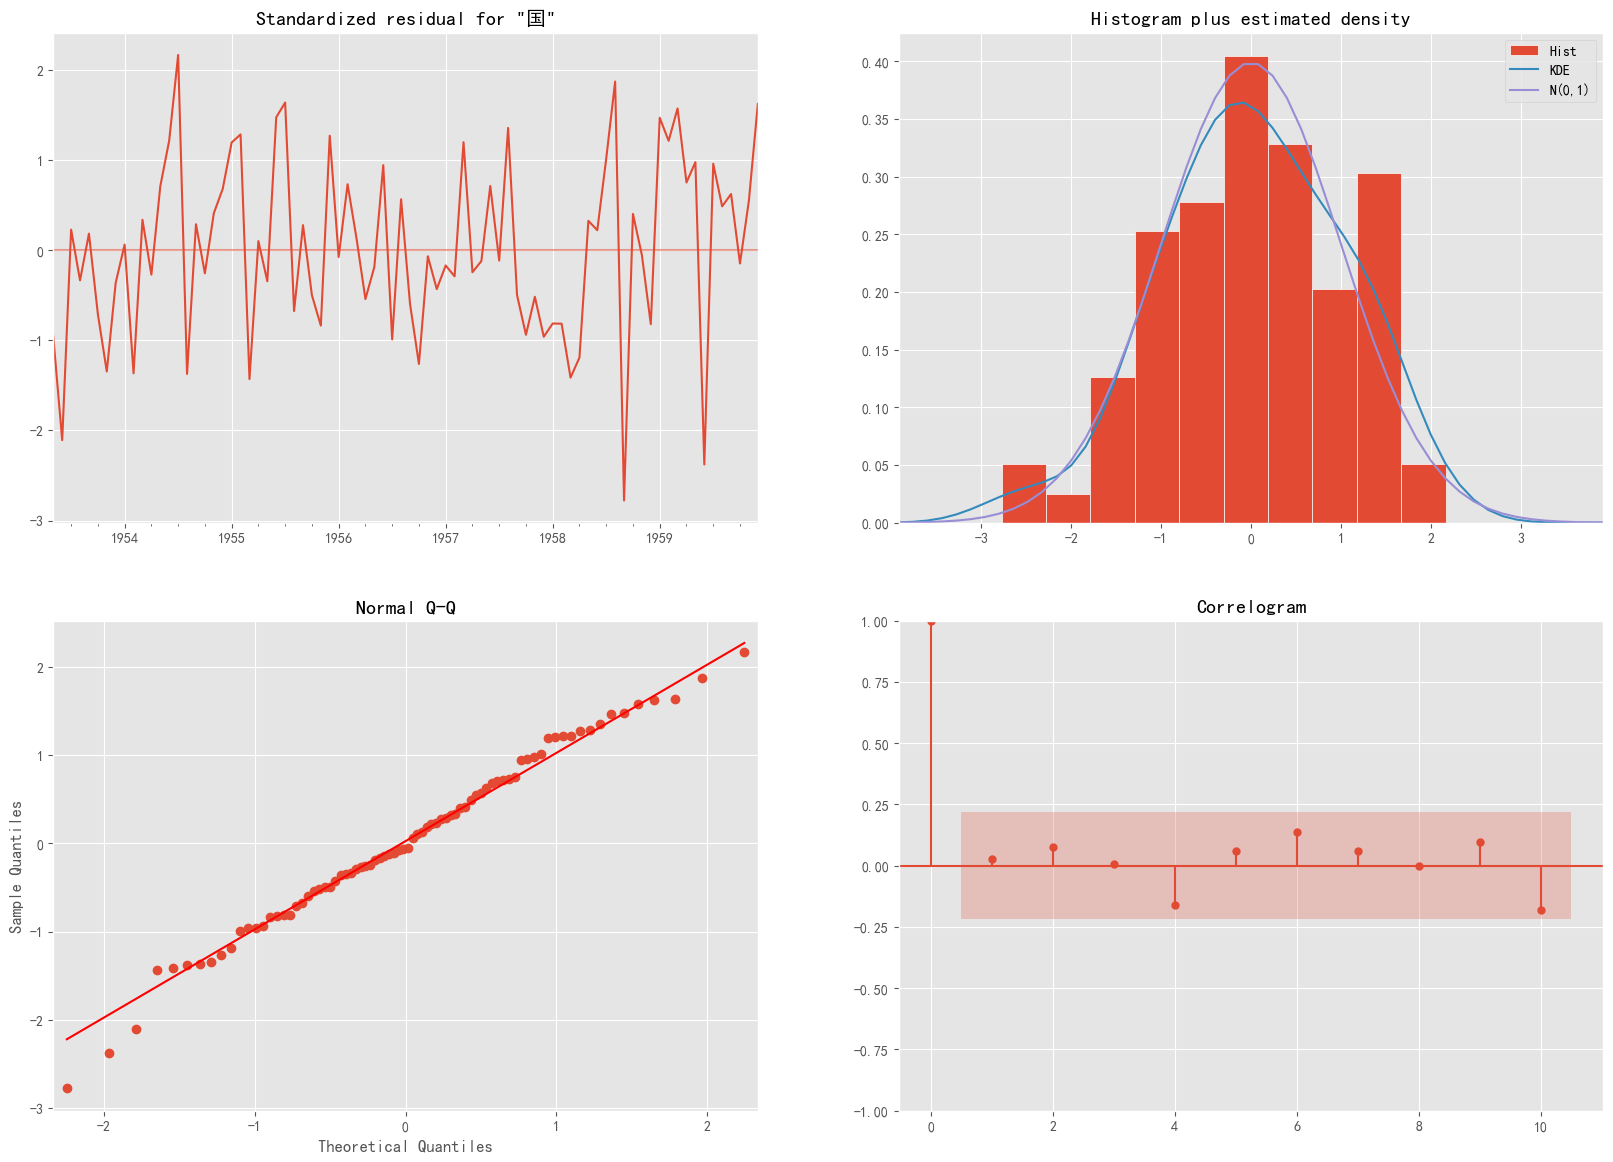

In [9]:
results.plot_diagnostics(figsize=(20, 14)) # 绘制诊断图
plt.show() # 显示图像

#参考资料：https://blog.csdn.net/mengjizhiyou/article/details/82216278
# Standardized residual 标准化残差
# 标准化残差是指内部的残差为了减少内部差异性（unconstant variance）而标准化的残差，便于观察其标准化后的残差做出相应的模型假设判断
# 在回归模型y=\beta _{0}+\beta _{1}x+\varepsilon 中，假定\varepsilon 的期望值为0，方差相等且服从正态分布的一个随机变量。但是，若关于\varepsilon的假定不成立，此时所做的检验以及估计和预测也许站不住脚。确定有关\varepsilon的假定是否成立的方法之一是进行残差分析（residual analysis）.


# Hisyogram plus estimated density 直方图和估计密度



# Normal Q-Q
# Q-Q图，全程Quantile-Quantile图，是把两个分布的quantile放在一起进行比较，来判断这两个分布是不是相似的。这幅图的作用就是检验误差是不是服从正态分布。如果是，这张图上的点将会贴近
# 这条直线。

#correlogram 相关图的意义
# 用于检验时间序列的平稳性


在上面的图中，我们可以观察到残差是不相关的（右下图），并且没有表现出任何明显的季节性（左上图）。此外，残差与零均值近似正态分布（右上图）。左下角的qq图显示，残差（蓝点）的有序分布顺序遵循从N（0，1）的标准正态分布中提取的样本的线性趋势。同样，这有力地表明残差是正态分布的。

## Results
Now let's create some predictions. We will use three methods:
现在让我们创建一些预测。我们将使用三种方法：

1)
上一年（1959年）的提前一步预测的样本内预测。在这种情况下，该模型用于预测建立该模型的数据。一步预测意味着每个预测点都用于预测下一个预测点。.

In [10]:
pred0 = results.get_prediction(start='1958-01-01', dynamic=False) # 预测
pred0_ci = pred0.conf_int()# 置信区间
pred0_ci

lower 国际航空公司乘客：每月总计数千人  upper 国际航空公司乘客：每月总计数千人
1958-01-01              328.434501              367.960928
1958-02-01              306.477585              345.925540
1958-03-01              356.500817              395.938005
1958-04-01              340.326595              379.445372
1958-05-01              340.182297              379.300624
1958-06-01              413.225149              452.343470
1958-07-01              461.293116              500.411436
1958-08-01              466.757923              505.876243
1958-09-01              412.144894              451.263214
1958-10-01              335.420999              374.539319
1958-11-01              290.977617              330.095926
1958-12-01              325.626639              364.744481
1959-01-01              325.792231              364.890834
1959-02-01              310.389618              349.430265
1959-03-01              370.810201              409.842885
1959-04-01              369.163804              407.956494
1959-05-01              390.929696              429.722040
1959-06-01              476.125756              514.918095
1959-07-01              519.104016              557.896355
1959-08-01              534.783706              573.576045
1959-09-01              437.431460              476.223799
1959-10-01              389.054363              427.846701
1959-11-01              337.144784              375.937114
1959-12-01              369.536471              408.328440


3) 采用上一年（1959年）的动态预测进行样本内预测。同样，该模型用于预测该模型所基于的数据。

In [11]:
pred1 = results.get_prediction(start='1958-01-01', dynamic=True)
pred1_ci = pred1.conf_int()
pred1_ci

lower 国际航空公司乘客：每月总计数千人  upper 国际航空公司乘客：每月总计数千人
1958-01-01              328.434501              367.960928
1958-02-01              307.994027              355.051070
1958-03-01              359.914553              415.339684
1958-04-01              350.058767              412.148600
1958-05-01              355.724951              424.017844
1958-06-01              424.681883              498.622447
1958-07-01              468.179186              547.373134
1958-08-01              464.505265              548.623925
1958-09-01              394.524245              483.294990
1958-10-01              331.984956              425.175982
1958-11-01              285.808597              383.218055
1958-12-01              317.741730              419.202631
1959-01-01              321.716735              440.362855
1959-02-01              296.946887              425.539929
1959-03-01              352.828308              491.809688
1959-04-01              341.664640              489.611688
1959-05-01              347.890720              504.559382
1959-06-01              422.120644              586.988126
1959-07-01              467.548371              640.239747
1959-08-01              463.348771              643.522045
1959-09-01              385.030208              572.387232
1959-10-01              316.556078              510.831618
1959-11-01              265.728186              466.681709
1959-12-01              297.277440              504.707710


4) 样本外数据的“真实”预测。在这种情况下，模型被要求预测以前从未见过的数据。

In [12]:
pred2 = results.get_forecast('1962-12-01')
pred2_ci = pred2.conf_int()
pred2_ci
# print(pred2.predicted_mean['1960-01-01':'1960-12-01']) # 打印预测值

lower 国际航空公司乘客：每月总计数千人  upper 国际航空公司乘客：每月总计数千人
1960-01-01              400.106429              438.883645
1960-02-01              374.744415              420.923357
1960-03-01              433.658605              488.059294
1960-04-01              418.937123              479.966028
1960-05-01              440.984840              508.126775
1960-06-01              501.491532              574.208688
1960-07-01              575.937165              653.836383
1960-08-01              586.833200              669.589895
1960-09-01              475.664667              563.009196
1960-10-01              416.403145              508.106358
1960-11-01              364.232140              460.095197
1960-12-01              402.737016              502.591574
1961-01-01              413.252421              529.275576
1961-02-01              384.160628              509.709234
1961-03-01              447.508777              582.989812
1961-04-01              431.805642              576.039599
1961-05-01              456.126455              608.787150
1961-06-01              517.479178              678.085738
1961-07-01              597.314312              765.500311
1961-08-01              607.845889              783.282637
1961-09-01              487.770262              670.169981
1961-10-01              423.519614              612.626234
1961-11-01              367.788614              563.370822
1961-12-01              408.014917              609.873003
1962-01-01              418.135994              638.003006
1962-02-01              384.934176              616.836919
1962-03-01              450.502242              694.936252
1962-04-01              433.237648              688.913591
1962-05-01              459.012165              725.706872
1962-06-01              523.562175              800.778101
1962-07-01              607.103792              894.469426
1962-08-01              617.577295              914.743663
1962-09-01              487.265815              793.920230
1962-10-01              418.742350              734.600123
1962-11-01              358.694206              683.492541
1962-12-01              399.082376              732.593032

In [16]:
pred0.predicted_mean

1958-01-01    348.197715
1958-02-01    326.201563
1958-03-01    376.219411
1958-04-01    359.885983
1958-05-01    359.741461
1958-06-01    432.784309
1958-07-01    480.852276
1958-08-01    486.317083
1958-09-01    431.704054
1958-10-01    354.980159
1958-11-01    310.536772
1958-12-01    345.185560
1959-01-01    345.341532
1959-02-01    329.909941
1959-03-01    390.326543
1959-04-01    388.560149
1959-05-01    410.325868
1959-06-01    495.521926
1959-07-01    538.500185
1959-08-01    554.179876
1959-09-01    456.827629
1959-10-01    408.450532
1959-11-01    356.540949
1959-12-01    388.932455
Freq: MS, Name: predicted_mean, dtype: float64

In [17]:
pred1.predicted_mean

1958-01-01    348.197715
1958-02-01    331.522549
1958-03-01    387.627118
1958-04-01    381.103684
1958-05-01    389.871397
1958-06-01    461.652165
1958-07-01    507.776160
1958-08-01    506.564595
1958-09-01    438.909617
1958-10-01    378.580469
1958-11-01    334.513326
1958-12-01    368.472180
1959-01-01    381.039795
1959-02-01    361.243408
1959-03-01    422.318998
1959-04-01    415.638164
1959-05-01    426.225051
1959-06-01    504.554385
1959-07-01    553.894059
1959-08-01    553.435408
1959-09-01    478.708720
1959-10-01    413.693848
1959-11-01    366.204948
1959-12-01    400.992575
Freq: MS, Name: predicted_mean, dtype: float64

In [15]:
pred2.predicted_mean

1960-01-01    419.495037
1960-02-01    397.833886
1960-03-01    460.858950
1960-04-01    449.451576
1960-05-01    474.555807
1960-06-01    537.850110
1960-07-01    614.886774
1960-08-01    628.211547
1960-09-01    519.336931
1960-10-01    462.254752
1960-11-01    412.163668
1960-12-01    452.664295
1961-01-01    471.263999
1961-02-01    446.934931
1961-03-01    515.249295
1961-04-01    503.922621
1961-05-01    532.456802
1961-06-01    597.782458
1961-07-01    681.407311
1961-08-01    695.564263
1961-09-01    578.970121
1961-10-01    518.072924
1961-11-01    465.579718
1961-12-01    508.943960
1962-01-01    528.069500
1962-02-01    500.885548
1962-03-01    572.719247
1962-04-01    561.075619
1962-05-01    592.359519
1962-06-01    662.170138
1962-07-01    750.786609
1962-08-01    766.160479
1962-09-01    640.593022
1962-10-01    576.671237
1962-11-01    521.093373
1962-12-01    565.837704
Freq: MS, Name: predicted_mean, dtype: float64

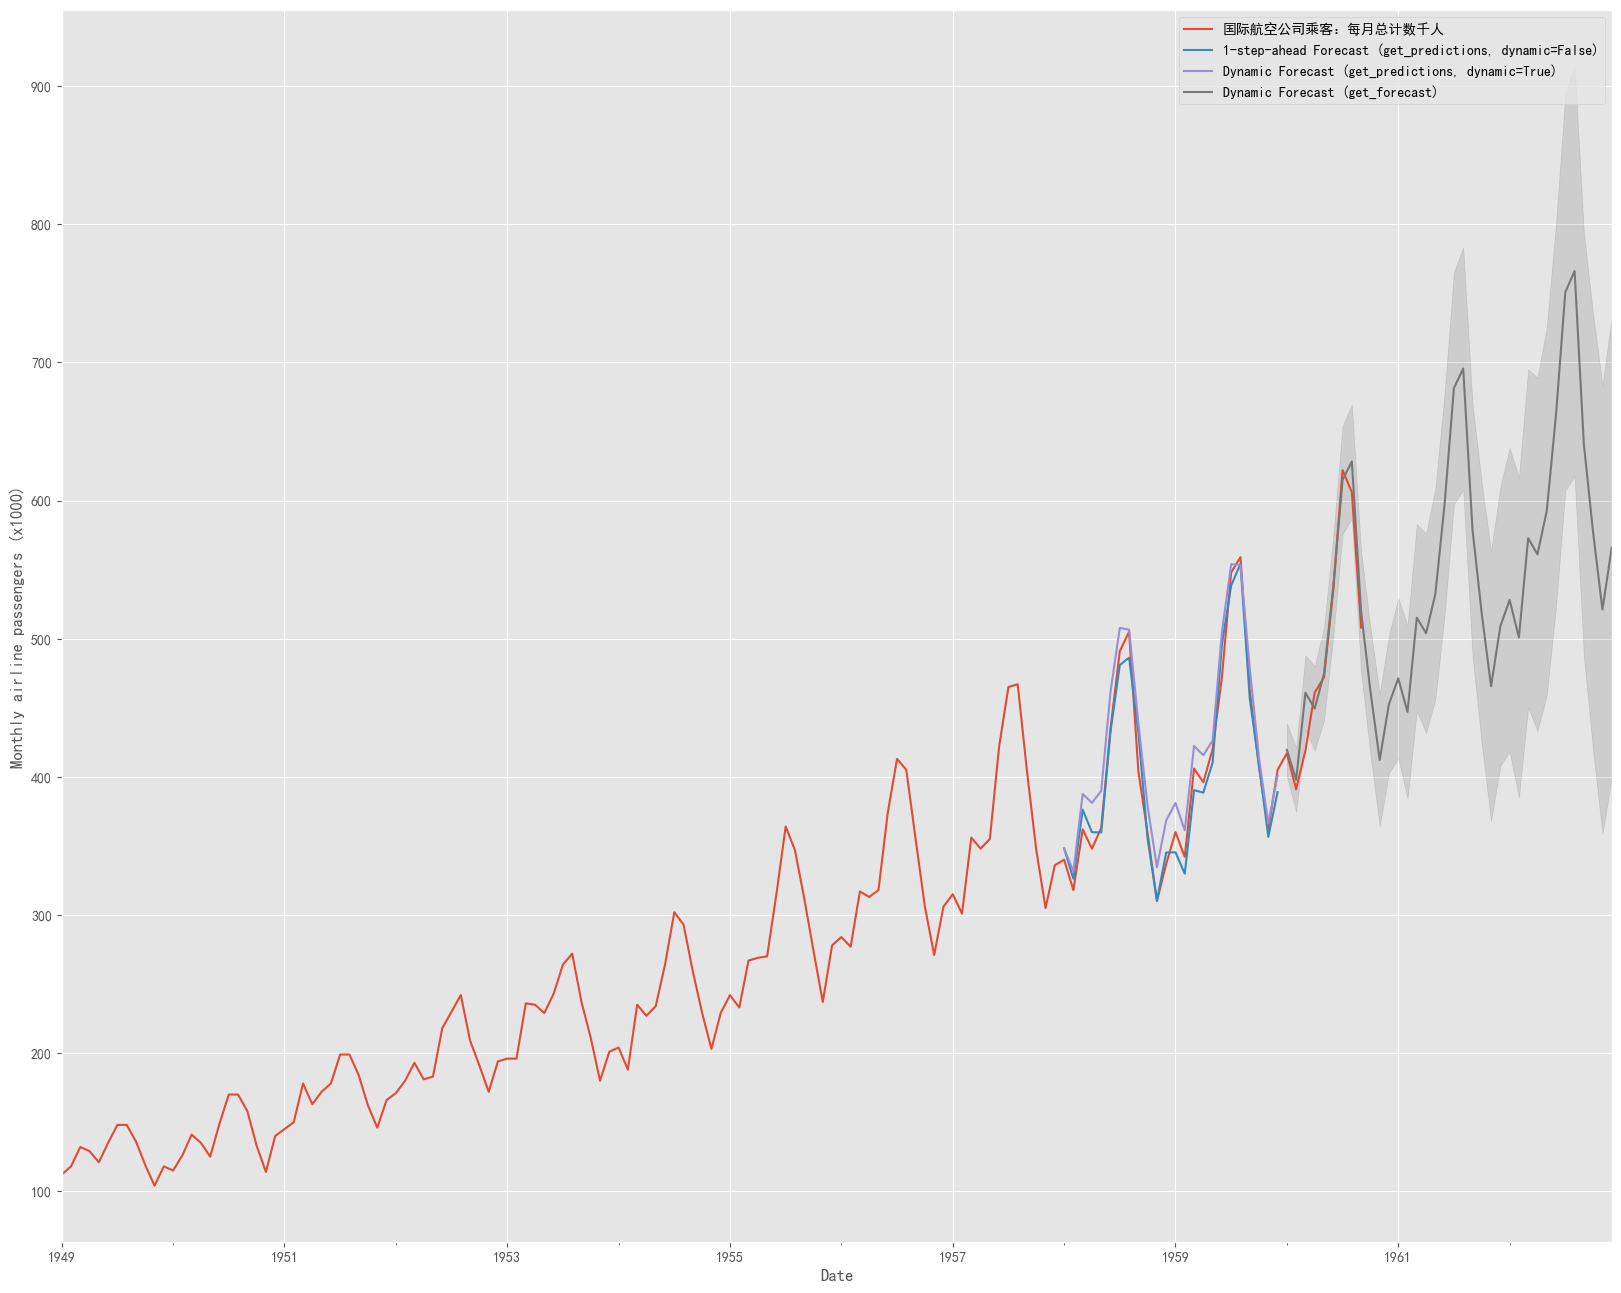

In [13]:
ax = data.plot(figsize=(20, 16))
pred0.predicted_mean.plot(ax=ax, label='1-step-ahead Forecast (get_predictions, dynamic=False)')
pred1.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_predictions, dynamic=True)')
pred2.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_forecast)')
ax.fill_between(pred2_ci.index, pred2_ci.iloc[:, 0], pred2_ci.iloc[:, 1], color='k', alpha=.1)
plt.ylabel('Monthly airline passengers (x1000)')
plt.xlabel('Date')
plt.legend()
plt.show()


从图上看，该模型似乎在时间序列建模方面做得很好。正如预期的那样，蓝色和紫色的线条非常接近红色地面的真相。更有趣的是灰线，即样本外预失真。对于这样一个简单的时间序列，ARIMA模型能够准确地预测1960年的数值。


为了量化1960年预测的准确性，我们可以计算平均绝对误差、均方误差或均方根误差等指标。这些都是绝对指标，因此与规模有关。虽然它们很有用，并且被广泛用于比较同一数据集上的不同方法，但在这里，相对于我们试图预测的时间序列的幅度来表达误差会更有用。一种常用的百分比误差度量是平均绝对百分比误差（MAPE）。它在特殊情况下有一些缺点（特别是，它可能导致除以零），并提出了改进措施，例如。https://www.otexts.org/fpp/2/5以获得一个很好的概述。然而，对于这个例子，我们将坚持使用MAPE。

In [14]:
prediction = pred2.predicted_mean['1960-01-01':'1960-9-01'].values
# flatten nested list
print(test_data)
truth = list(itertools.chain.from_iterable(test_data.values))
# Mean Absolute Percentage Error
MAPE = np.mean(np.abs((truth - prediction) / truth)) * 100

print('1960年预测的平均绝对百分比误差为 {:.2f}%'.format(MAPE))

            国际航空公司乘客：每月总计数千人
Month                       
1960-01-01               417
1960-02-01               391
1960-03-01               419
1960-04-01               461
1960-05-01               472
1960-06-01               535
1960-07-01               622
1960-08-01               606
1960-09-01               508
1960年预测的平均绝对百分比误差为 2.55%
